# Neural network implementation

_by Hasan Kamal, hasankamal007@gmail.com_

- This jupyter notebook contains working implementation of a vectorized fully connected neural network in NumPy.
- Backpropagation algorithm is implemented in a full-vectorized fashion over a given minibatch
- This enables us to take advantage of powerful built-in NumPy APIs (and avoid clumsy nested loops!), consequently improving training speed
- Backpropagation code lies in method *take_gradient_step_on_minibatch* of class _NeuralNetwork_

Contents of this notebook:
1. Implement class _NeuralNetwork_
2. Implement common activation and loss functions
3. Test implementation on MNIST data

### 1. Implement class _NeuralNetwork_

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np

class NeuralNetwork:
    """ Class implementation of a fully-connected neural network """
    
    
    def __init__(self, layers, loss, init_strategy):
        """
        Initializes the architecture of neural network.
        
        Parameters:
            layers (list)       : list of dicts describing each layer
            loss    (str)       : loss to optimize
            init_strategy (dict): dict specifying weight initialization strategy
        """
        
        # validate parameters
        for i, layer in enumerate(layers):
            assert 'num_neurons' in layer, 'please provide num_neurons for each layer'
            if i > 0:
                assert 'activation' in layer, 'please provide activation for each layer after input layer'
                assert layer['activation'] in activations.keys(), 'unknown activation found'
        assert loss in losses.keys(), 'unknown loss function found'
        
        # create random initial weights and biases for each layer (sampling uniformly in range [w_init_min, w_init_max])
        self.L = len(layers)
        self.layers = layers
        self.loss = loss
        self.w = {}
        self.b = {}
        for i in range(2, self.L + 1):
            if init_strategy['type'] == 'uniform':
                self.w[i] = np.random.uniform(low=init_strategy['min'], high=init_strategy['max'], size=(layers[i - 1]['num_neurons'], layers[i - 2]['num_neurons']))
                self.b[i] = np.random.uniform(low=init_strategy['min'], high=init_strategy['max'], size=(layers[i - 1]['num_neurons'], ))
            elif init_strategy['type'] == 'gaussian':
                self.w[i] = np.random.normal(loc=init_strategy['mean'], scale=init_strategy['std. dev'], size=(layers[i - 1]['num_neurons'], layers[i - 2]['num_neurons']))
                self.b[i] = np.random.normal(loc=init_strategy['mean'], scale=init_strategy['std. dev'], size=(layers[i - 1]['num_neurons'], ))
            elif init_strategy['type'] == 'gaussian_scaled':
                self.w[i] = np.random.normal(loc=init_strategy['mean'], scale=init_strategy['std. dev'], size=(layers[i - 1]['num_neurons'], layers[i - 2]['num_neurons'])) * math.sqrt(2.0 / layers[i - 2]['num_neurons'])
                self.b[i] = np.random.normal(loc=init_strategy['mean'], scale=init_strategy['std. dev'], size=(layers[i - 1]['num_neurons'], )) * math.sqrt(2.0 / layers[i - 2]['num_neurons'])
            else:
                assert False, 'unknown init strategy provided'
                
    
    def fit(self, X_train, Y_train, X_test, Y_test, learning_rate, batch_size, epochs):
        """
        Trains the neural network on given matrices and plots training/testing errors per epoch.
        
        Parameters:
            X_train (np array): training samples, dim num_features x num_samples
            Y_train (np array): training labels,  dim num_classes x num_samples
            X_test  (np array): testing samples, dim num_features x num_samples
            Y_test  (np array): testing labels,  dim num_classes  x num_samples
            learning_rate (float): learning rate of stochastic gradient descent
            batch_size      (int): gradient step is taken over a single batch of this size
            epochs          (int): number of epochs to train for
        """
        
        num_samples = X_train.shape[1]
        train_accuracy, test_accuracy, train_error, test_error = [], [], [], []
        
        for epoch in range(epochs):
            # print progress
            train_accuracy_this_epoch = self.score(X_train, Y_train)
            test_accuracy_this_epoch = self.score(X_test, Y_test)
            train_accuracy.append(train_accuracy_this_epoch)
            test_accuracy.append(test_accuracy_this_epoch)
            train_error.append(self.get_error(X_train, Y_train))
            test_error.append(self.get_error(X_test, Y_test))
            print('{}/{} #epochs done, train_accuracy = {:.3f}, test_accuracy = {:.3f}'.format(epoch, epochs, train_accuracy_this_epoch, test_accuracy_this_epoch))
            
            # train on each minibatch
            for i in range(0, num_samples, batch_size):
                X_minibatch = X_train.T[i:i + batch_size, :].T
                Y_minibatch = Y_train.T[i:i + batch_size, :].T
                self.take_gradient_step_on_minibatch(X_minibatch, Y_minibatch, learning_rate)            
            
        # print final accuracies
        print('{}/{} #epochs done, train_accuracy = {:.3f}, test_accuracy = {:.3f}'.format(epochs, epochs, self.score(X_train, Y_train), self.score(X_test, Y_test)))
    
        # plot accuracy plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig.suptitle('Accuracy as a function of training epochs')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epochs')
        ax.plot(range(len(train_accuracy)), train_accuracy, color='blue')
        ax.plot(range(len(train_accuracy)), train_accuracy, marker='o', color='blue', label='Train accuracy')
        ax.plot(range(len(test_accuracy)), test_accuracy, color='#f39c12')
        ax.plot(range(len(test_accuracy)), test_accuracy, marker='o', color='#f39c12', label='Test accuracy')
        ax.legend()
        plt.show()
        plt.close(fig)
        
        # plot loss plot
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        fig.suptitle('Loss as a function of training epochs')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epochs')
        ax.plot(range(len(train_error)), train_error, color='blue')
        ax.plot(range(len(train_error)), train_error, marker='o', color='blue', label='Train loss')
        ax.plot(range(len(test_error)), test_error, color='#f39c12')
        ax.plot(range(len(test_error)), test_error, marker='o', color='#f39c12', label='Test loss')
        ax.legend()
        plt.show()
        plt.close(fig)
    

    def take_gradient_step_on_minibatch(self, X_minibatch, Y_minibatch, learning_rate):
        """
        This method takes one gradient step using minibatch provided as parameter.
        This method contains the actual backpropagation code.
        
        Parameters:
            X_minibatch (np array): minibatch training samples, dim num_features x num_samples in minibatch
            Y_minibatch (np array): minibatch training labels,  dim  num_classes x num_samples in minibatch
            learning_rate  (float): learning rate of stochastic gradient descent
        """
        
        # forward pass
        z, a = {}, {}
        a[1] = X_minibatch
        for l in range(2, self.L + 1):
            z[l] = ( np.matmul(self.w[l], a[l - 1]).T + self.b[l] ).T
            a[l] = activations[self.layers[l - 1]['activation']]['sigma'](z[l])
        
        # backward pass
        delta = {}
        delta[self.L] = np.multiply( losses[self.loss]['gradient_wrt_last_activation'](a[self.L], Y_minibatch), activations[self.layers[-1]['activation']]['sigma_prime'](z[self.L]) )
        for l in range(self.L - 1, 1, -1):
            delta[l] = np.multiply(np.matmul(self.w[l + 1].T, delta[l + 1]), activations[self.layers[l - 1]['activation']]['sigma_prime'](z[l]))
        
        # compute gradients
        dw, db = {}, {}
        for l in range(self.L, 1, -1):
            dw[l] = np.matmul(delta[l], a[l-1].T) / float(X_minibatch.shape[1])
            db[l] = np.mean(delta[l], axis=1)
        
        # take gradient step
        for l in range(self.L, 1, -1):
            self.w[l] = self.w[l] - ( learning_rate * dw[l] )
            self.b[l] = self.b[l] - ( learning_rate * db[l] )
                

    def forward(self, X):
        """
        Computes forward-pass i.e. output (probabilities) on samples of X
        
        Parameters:
            X (np array): samples, dim num_features x num_samples
        
        Returns:
            A_L (np array): output probabilities, dim num_classes x num_samples
        """
        
        z, a = {}, {}
        a[1] = X
        for l in range(2, self.L + 1):
            z[l] = ( np.matmul(self.w[l], a[l - 1]).T + self.b[l] ).T
            a[l] = activations[self.layers[l - 1]['activation']]['sigma'](z[l])
        return a[self.L]
    
    
    def predict(self, X):
        """
        Computes predictions (labels) on samples of X, made by this neural network
        
        Parameters:
            X (np array): samples, dim num_features x num_samples
        
        Returns:
            Y (np array): predicted labels, dim (num_samples,)
        """
        
        Y_scores = self.forward(X)
        return np.argmax(Y_scores, axis=0)
    
    
    def score(self, X, Y):
        """
        Computes accuracy of this (possibly trained) neural network on X, Y

        Parameters:
            X (np array): samples, dim num_features x num_samples
            Y (np array): labels,  dim num_classes x num_samples
            
        Returns:
            float: accuracy of model on X, Y
        """
        
        Y_predicted_labels = self.predict(X)
        Y_labels = np.argmax(Y, axis=0)
        N = float(X.shape[1])
        return np.sum(Y_predicted_labels == Y_labels) / N

    
    def get_error(self, X, Y):
        """
        Computes error (i.e. loss) value of this model on X, Y

        Parameters:
            X (np array): samples, dim num_features x num_samples
            Y (np array): labels,  dim num_classes x num_samples
            
        Returns:
            float: loss of model on X, Y
        """
        
        A_L = self.forward(X)
        return losses[self.loss]['error'](A_L, Y)

Now that we have implemented the neural network, let us implement activation and loss functions that are used commonly

### 2. Implement common activation and loss functions

In [6]:
# list of activations and their corresponding forward, backward functions
activations = {
    'sigmoid':{
        'sigma': lambda z: 1.0 / (1.0 + np.exp(-z)),
        'sigma_prime': lambda z: np.multiply(1.0 / (1.0 + np.exp(-z)), 1.0 - (1.0 / (1.0 + np.exp(-z))))
        },
    'relu':{
        'sigma': lambda z: np.maximum(np.zeros(shape=z.shape), z),
        'sigma_prime': lambda z: np.where(z <= 0.0, 0.0, 1.0)
        },
    'softmax': {
        'sigma': lambda z: np.exp(z - np.max(z, axis=0)) / np.sum(np.exp(z - np.max(z, axis=0)), axis=0),
        'sigma_prime': lambda z: np.multiply( np.exp(z - np.max(z, axis=0)) / np.sum(np.exp(z - np.max(z, axis=0)), axis=0), 1.0 - ( np.exp(z - np.max(z, axis=0)) / np.sum(np.exp(z - np.max(z, axis=0)), axis=0) ) )
    },
    'linear':{
        'sigma': lambda z: z,
        'sigma_prime': lambda z: np.ones(shape=z.shape)
    },
    'tanh':{
        'sigma': lambda z: ( 2.0 * 1.0 / (1.0 + np.exp(-2.0 * z)) ) - 1.0,
        'sigma_prime': lambda z: 1.0 - np.square( ( 2.0 * 1.0 / (1.0 + np.exp(-2.0 * z)) ) - 1.0 )
    }
}

# list of loss functions and their corresponding forward, backward functions
losses = {
    'mse': {
        'error': lambda A_L, Y: np.mean((np.sum(np.multiply(Y - A_L, Y - A_L), axis=0))),
        'gradient_wrt_last_activation': lambda A_L, Y: A_L - Y
    }
}

Let us test these functions with some concrete values

In [8]:
# checking some values
print(activations['sigmoid']['sigma'](np.eye(2)))
print(activations['sigmoid']['sigma_prime'](np.eye(2)))
print(losses['mse']['error'](np.array( [ [0, 0, 0.5], [0.5, 0.5, 0] ] ), np.array( [ [0, 1, 0], [1, 0, 1] ] )))
print(activations['softmax']['sigma'](np.array( [ [1, 2, 3], [4, 3, 1] ] )))
print(activations['relu']['sigma'](np.array( [ [0, -0.3, 0.5], [-0.5, -0.5, 0.3] ] )))
print(activations['relu']['sigma_prime'](np.array( [ [0, -0.3, 0.5], [-0.5, -0.5, 0.3] ] )))
print(activations['linear']['sigma'](np.array( [ [0, -0.3, 0.5], [-0.5, -0.5, 0.3] ] )))
print(activations['linear']['sigma_prime'](np.array( [ [0, -0.3, 0.5], [-0.5, -0.5, 0.3] ] )))
print(activations['tanh']['sigma'](np.array( [ [0, -0.3, 0.5], [-0.5, -0.5, 0.3] ] )))
print(activations['tanh']['sigma_prime'](np.array( [ [0, -0.3, 0.5], [-0.5, -0.5, 0.3] ] )))

[[0.73105858 0.5       ]
 [0.5        0.73105858]]
[[0.19661193 0.25      ]
 [0.25       0.19661193]]
0.9166666666666666
[[0.04742587 0.26894142 0.88079708]
 [0.95257413 0.73105858 0.11920292]]
[[0.  0.  0.5]
 [0.  0.  0.3]]
[[0. 0. 1.]
 [0. 0. 1.]]
[[ 0.  -0.3  0.5]
 [-0.5 -0.5  0.3]]
[[1. 1. 1.]
 [1. 1. 1.]]
[[ 0.         -0.29131261  0.46211716]
 [-0.46211716 -0.46211716  0.29131261]]
[[1.         0.91513696 0.78644773]
 [0.78644773 0.78644773 0.91513696]]


The above values are correct

### 3. Test implementation on MNIST data

Install [https://pypi.org/project/python-mnist/](python-mnist). Ensure `python-mnist` directory exists (with the data) inside the same directory which contains this notebook.

First, load MNIST data

In [10]:
from mnist import MNIST

# returns one-hot encoded Y
def one_hot_encode(Y_label, num_classes):
    Y = np.zeros(shape=(Y_label.shape[0], num_classes))
    for i in range(Y_label.shape[0]):
        Y[i, Y_label[i]] = 1.0
    return Y

# load training data and create X_train, Y_train numpy arrays
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_training()
X_train = np.array(images)
Y_train_labels = np.array(labels)
Y_train = one_hot_encode(Y_train_labels, 10)

# load testing data and create X_test, Y_test numpy arrays
mndata = MNIST('./python-mnist/data')
images, labels = mndata.load_testing()
X_test = np.array(images)
Y_test_labels = np.array(labels)
Y_test = one_hot_encode(Y_test_labels, 10)

Now, standardize (normalize) the data before training

In [11]:
# standardize data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Train on a simple neural network having 1 hidden-layer

0/20 #epochs done, train_accuracy = 0.098, test_accuracy = 0.097
1/20 #epochs done, train_accuracy = 0.104, test_accuracy = 0.103
2/20 #epochs done, train_accuracy = 0.256, test_accuracy = 0.256
3/20 #epochs done, train_accuracy = 0.555, test_accuracy = 0.555
4/20 #epochs done, train_accuracy = 0.732, test_accuracy = 0.736
5/20 #epochs done, train_accuracy = 0.838, test_accuracy = 0.842
6/20 #epochs done, train_accuracy = 0.877, test_accuracy = 0.878
7/20 #epochs done, train_accuracy = 0.891, test_accuracy = 0.894
8/20 #epochs done, train_accuracy = 0.898, test_accuracy = 0.899
9/20 #epochs done, train_accuracy = 0.904, test_accuracy = 0.903
10/20 #epochs done, train_accuracy = 0.908, test_accuracy = 0.907
11/20 #epochs done, train_accuracy = 0.911, test_accuracy = 0.909
12/20 #epochs done, train_accuracy = 0.914, test_accuracy = 0.912
13/20 #epochs done, train_accuracy = 0.916, test_accuracy = 0.914
14/20 #epochs done, train_accuracy = 0.918, test_accuracy = 0.917
15/20 #epochs done, 

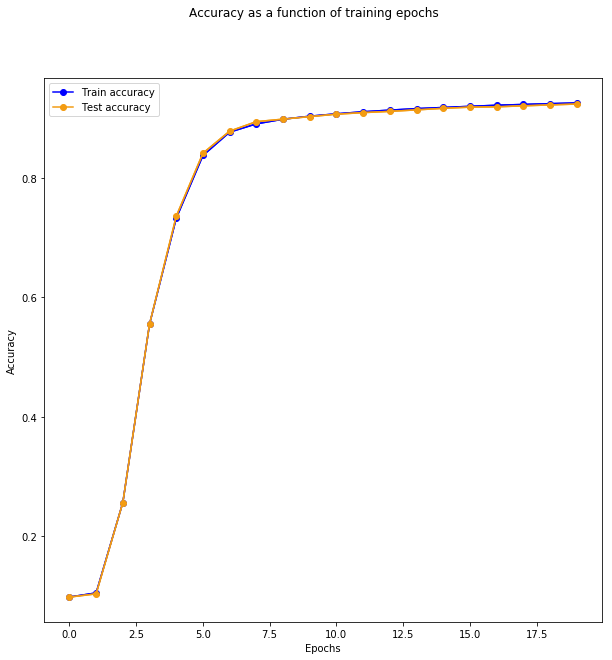

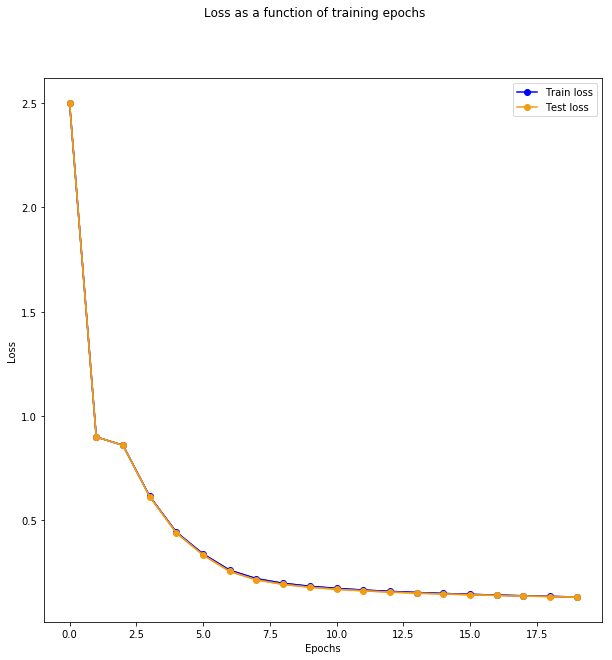

In [12]:
nn_model = NeuralNetwork(
    layers = [
        {'num_neurons': 784},
        {'num_neurons': 256, 'activation': 'sigmoid'},
        {'num_neurons': 10, 'activation': 'sigmoid'}
    ],
    loss='mse',
    init_strategy={'type': 'uniform', 'min': -0.001, 'max': 0.001}
)
nn_model.fit(
    X_train=X_train_scaled.T,
    Y_train=Y_train.T,
    X_test=X_test_scaled.T,
    Y_test=Y_test.T,
    learning_rate=0.1,
    batch_size=100,
    epochs=20)

Train a neural network having 3 hidden-layers

0/20 #epochs done, train_accuracy = 0.110, test_accuracy = 0.111
1/20 #epochs done, train_accuracy = 0.352, test_accuracy = 0.346
2/20 #epochs done, train_accuracy = 0.477, test_accuracy = 0.475
3/20 #epochs done, train_accuracy = 0.567, test_accuracy = 0.568
4/20 #epochs done, train_accuracy = 0.634, test_accuracy = 0.634
5/20 #epochs done, train_accuracy = 0.683, test_accuracy = 0.683
6/20 #epochs done, train_accuracy = 0.721, test_accuracy = 0.721
7/20 #epochs done, train_accuracy = 0.748, test_accuracy = 0.749
8/20 #epochs done, train_accuracy = 0.769, test_accuracy = 0.768
9/20 #epochs done, train_accuracy = 0.785, test_accuracy = 0.785
10/20 #epochs done, train_accuracy = 0.798, test_accuracy = 0.797
11/20 #epochs done, train_accuracy = 0.809, test_accuracy = 0.807
12/20 #epochs done, train_accuracy = 0.818, test_accuracy = 0.814
13/20 #epochs done, train_accuracy = 0.826, test_accuracy = 0.823
14/20 #epochs done, train_accuracy = 0.833, test_accuracy = 0.828
15/20 #epochs done, 

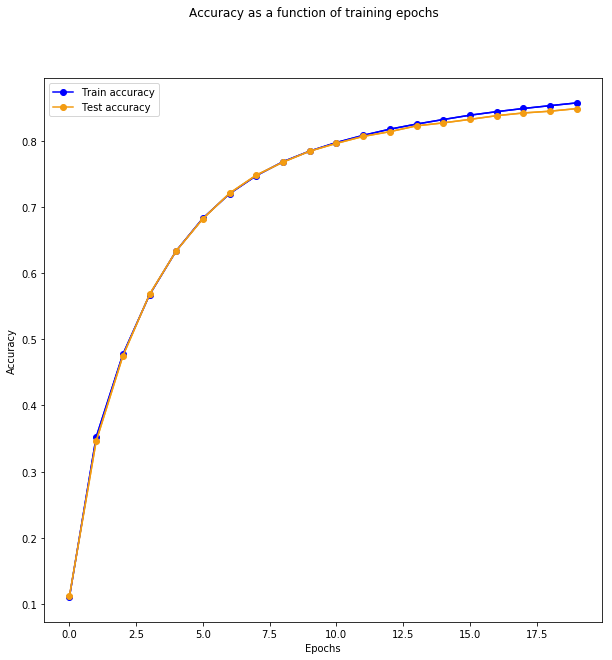

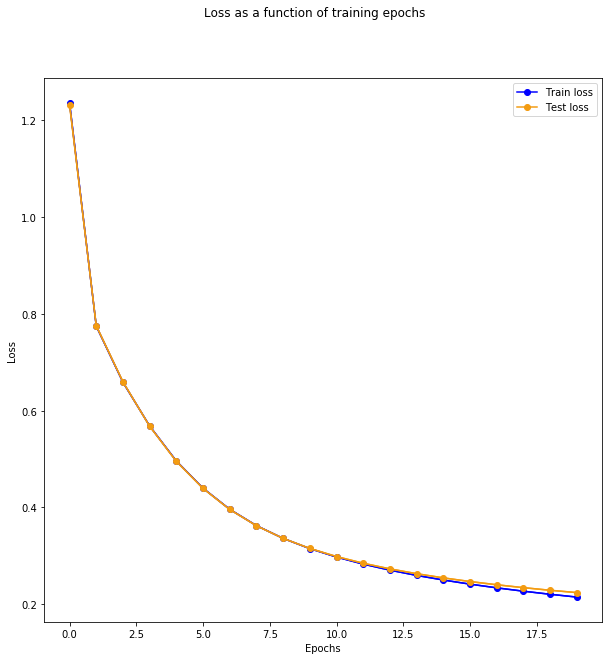

In [14]:
nn_model = NeuralNetwork(
    layers = [
        {'num_neurons': 784},
        {'num_neurons': 256, 'activation': 'sigmoid'},
        {'num_neurons': 128, 'activation': 'sigmoid'},
        {'num_neurons': 64, 'activation': 'sigmoid'},
        {'num_neurons': 10, 'activation': 'softmax'}
    ],
    loss='mse',
    init_strategy={'type': 'uniform', 'min': -1.0, 'max': 1.0}
)
nn_model.fit(
    X_train=X_train_scaled.T,
    Y_train=Y_train.T,
    X_test=X_test_scaled.T,
    Y_test=Y_test.T,
    learning_rate=0.1,
    batch_size=100,
    epochs=20)

Analyze results of the above model by plotting confusion matrix

In [23]:
# create function to show confusion matrix
%matplotlib inline
import matplotlib.ticker as ticker

def show_confusion_matrix(y_predicted, y_true, label_to_string_map=None):
    """
    Plots confusion matrix between provided labels.
    
    Parameters:
        y_predicted (np array)    : predicted labels, dim ( num samples, )
        y_true      (np array)    : true labels,      dim ( num samples, )
        label_to_string_map (dict): map specifying string to be displayed for each label
    """
    
    labels, counts = np.unique(y_true, return_counts=True)
    map_label_to_index = { label : i for i, label in enumerate(labels) }
    
    # compute confusion matrix
    confusion_matrix = np.zeros((labels.shape[0], labels.shape[0]))
    for prediction_label, true_label in zip(y_predicted, y_true):
        confusion_matrix[map_label_to_index[true_label], map_label_to_index[prediction_label]] += 1
    
    # plot confusion matrix
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    fig.suptitle('Confusion matrix', fontsize=16)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    labels_yaxes = [ '{} [{}]'.format(label_to_string_map[label], label) for i, label in enumerate(labels) ]
    labels_xaxes = [ '[{}] {}'.format(label, label_to_string_map[label]) for i, label in enumerate(labels) ]
    ax.set_xticklabels([''] + labels_xaxes)
    ax.set_yticklabels([''] + labels_yaxes)
    im = ax.matshow(confusion_matrix, cmap='coolwarm')
    # attribution for following two lines: https://stackoverflow.com/questions/20998083/show-the-values-in-the-grid-using-matplotlib
    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, '{}'.format(z), ha='center', va='center')
    fig.colorbar(im)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.tick_params(axis='x', labelrotation=60)
    plt.show()

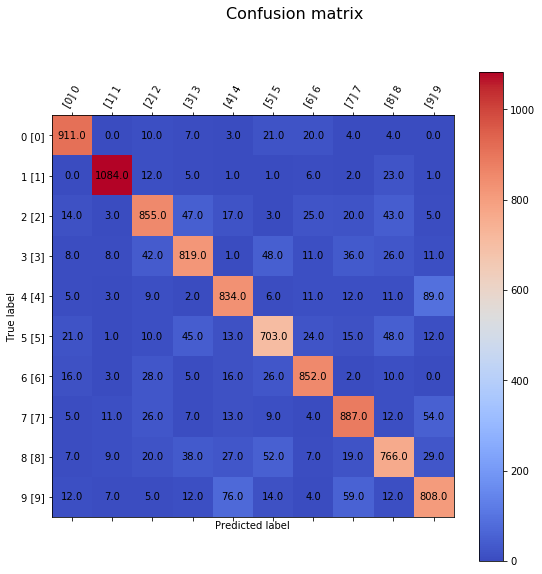

In [19]:
Y_predicted_labels = nn_model.predict(X_test_scaled.T)
label_to_string_map = { i : i for i in range(10) }
show_confusion_matrix(Y_predicted_labels, Y_test_labels, label_to_string_map)